In [127]:
%matplotlib inline

import numpy as np

import pandas as pd 
pd.__version__
from lmfit import Parameters, Model
import matplotlib.pyplot as plt
# Use the seborn style
#plt.style.use('seaborn')
#import tikzplotlib
import re
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF
from rdflib.plugins.sparql import prepareQuery

from shapely import Polygon, Point
from matolab_tools import annotate_csv_uri, csvw_to_rdf , create_mapping, get_joined_rdf 

#fetch sematic data and query for datasets and rois
PMD_CO=Namespace("https://w3id.org/pmd/co/")
OME=Namespace("https://github.com/Mat-O-Lab/OmeroExtractor/raw/main/ome.ttl#")
QUDT = Namespace("http://qudt.org/schema/qudt/")
OA = Namespace("http://www.w3.org/ns/oa#")
QUDT_UNIT_URL = 'https://raw.githubusercontent.com/qudt/qudt-public-repo/main/vocab/unit/VOCAB_QUDT-UNITS-ALL-v2.1.ttl'
QUNIT = Namespace("http://qudt.org/vocab/unit/")

units_graph = Graph()
units_graph.parse(QUDT_UNIT_URL, format='turtle')


def clean_string(string):
  return re.sub('[^A-Za-z0-9]+','', string )

def get_unit_symbol(qudt_unit):
  return str(units_graph.value(qudt_unit,QUDT.symbol))

def get_histogram(y, start=0.0, end=None, bin_width=1.0,x_label='x',plot_result=False) -> pd.DataFrame:
    #num_bins=int((max_x-min_x)/bin_width)
    y_label="normalized count"
    if not end:
       end=max(y)
    # default half open edges, last bin is regular bin_with edge to max(x)
    bin_edges=np.arange(start, end, bin_width)
    count, bin_edges= np.histogram(y,bins=bin_edges)
    
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    hist=pd.DataFrame({'center': bin_centers, 'count': count})
    hist['norm']=hist['count']/hist['count'].sum()
    if plot_result:
        plt.figure()
        plt.bar(hist['center'], hist['count'], width=bin_width, alpha=0.5,align='center')
        plt.xlabel(x_label)
        plt.ylabel('count')
        plt.show()
    return hist

#log distrubition fumction
def rock(x, rm, sigma):
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def fit_log_distribution(x, y, x_min=None, x_max=None, y_max=0.0, bin_width=1.0, label='distribution', x_label=r"$x$", y_label=r"probability density", filename='fit_log_distribution.png', save_plot=False) -> dict:
   results=dict()
   if not x_min:
      x_min=0
   if not x_max:
      x_max=max(x)
   x_sim=np.linspace(x_min,x_max,300)
   #https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
   fit=pd.DataFrame(columns=('x','y','dely'))
   model = Model(rock)
   #params = model.make_params(sigma=3.0, rm=1.0)
   params = Parameters()
   #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
   params.add('sigma', value=1, min=0.1, max=100.0,vary=True)
   params.add('rm', value=5.0, min=0.5,max=100, vary=True)
   result = model.fit(y, params, x=x)
   print(result.fit_report())
   
   fit['x']=x_sim
   fit['y']=model.eval(x=x_sim, params=result.params)
   fit['dely'] = result.eval_uncertainty(x=x_sim)
   results['chi squared']=result.chisqr
   # results.at[key,'R squared']=result.rsquared
   # results.at[key,'amplitude']=result.params['amp'].value
   # results.at[key,'amplitude stderr']=result.params['amp'].stderr
   results['rm']=result.params['rm'].value
   results['rm stderr']=result.params['rm'].stderr
   results['sigma']=result.params['sigma'].value
   results['sigma stderr']=result.params['sigma'].stderr
   results['ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
   results['ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
   results['n_bins']=len(x)
   results['start']=x_min
   results['end']=x_max
   results['bin_width']=bin_width
   results['fit']=fit
   fig=plt.figure(figsize=(4,2))
   plt.tight_layout()
   ax=plt.axes()
   #ax.set_facecolor((.94, .94, .94))
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   #ax.yaxis.grid(True, color='#EEEEEE')
   #ax.xaxis.grid(False)
   #plt.title(r"log normal fit $r_m={:.2f}\pm{:.2f}$, $\sigma={:.2f}\pm{:.2f}$".format(result.params['rm'].value,result.params['rm'].stderr,result.params['sigma'].value,result.params['sigma'].stderr))
   bars=ax.bar(x, y, width=bin_width, alpha=0.5,align='center', linewidth=0.2, edgecolor='gray', label=label)
   plt.plot(fit['x'], fit['y'], label=r"Log-normal fit: $r_m={:.2f}\pm{:.2f}$, $\sigma={:.2f}\pm{:.2f}$".format(result.params['rm'].value,result.params['rm'].stderr,result.params['sigma'].value,result.params['sigma'].stderr))
   plt.fill_between(fit['x'], fit['y']-fit['dely'],
         fit['y']+fit['dely'], color='#888888',alpha=0.3)
   plt.xlabel(x_label)
   plt.xlim(left=x_min,right=x_max)
   plt.ylim(bottom=0)
   bar_color = bars[0].get_facecolor()
   # for bar in bars:
   #    ax.text(
   #       bar.get_x() + bar.get_width() / 2,
   #       bar.get_height(),
   #       round(bar.get_height(), 1),
   #       horizontalalignment='center',
   #       color=bar_color,
   #       weight='bold'
   #    )
   if y_max:
      plt.ylim(top=y_max)
   
   #plt.xticks(x)
   plt.ylabel(y_label)
   plt.legend()
   plt.show()
   if save_plot:
      fig.savefig(filename)
   plt.close(fig)   
   return results

meta=Graph()
meta.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs-joined.ttl",format='turtle')
#meta.parse("./detection_runs-joined.ttl")
#add inverse relations
for s,p,o in meta.triples((None,PMD_CO.isResourceOf,None)):
   meta.add((o,PMD_CO.resource,s))
for s,p,o in meta.triples((None,PMD_CO.characteristic,None)):
   meta.add((o,PMD_CO.characteristicOf,s))
#meta.serialize('detection_runs-joined.ttl')

# Distribution Formula
$$X = \frac{1}{\sqrt{2 \pi} x \sigma} \exp{\left(-\frac{(\ln{x}-\ln{r_m})^2}{2 \sigma^2}\right)}$$

In [91]:
#fetching data from joined graph
q = prepareQuery(
    """
    SELECT ?ome_image ?ome_rois ?specimen_label ?chartype ?charvalue ?charunit WHERE 
    {
          ?image rdf:type co:Image ;
            co:resource / rdf:first ?ome_image.
          ?image_process co:output ?image ;
            co:nextProcess ?analysis_process ;
            co:input ?specimen .
          ?analysis_process co:output ?rois.
          ?rois co:resource / rdf:first ?ome_rois.
          ?creep_process co:nextProcess ?image_process;
            co:input [ a ?chartype;
              co:resource / qudt:value ?charvalue;
              co:resource / qudt:unit ?charunit].
          ?specimen co:characteristic [ a co:SpecimenName;
              co:resource / oa:hasBody / oa:value ?specimen_label].
    }
    """
    ,
    initNs = { "co": PMD_CO, "ome": OME, "rdf": RDF, "oa": OA, "qudt": QUDT}
)
qres = meta.query(q)
#print(list(qres)[:10])
df = pd.DataFrame(qres, columns =["ome_image", "ome_rois", "specimen_label", "parameter", "value", "unit"])
#remove rows names individual
df = df[df["parameter"] != URIRef("http://www.w3.org/2002/07/owl#NamedIndividual")]
result=df.iloc[:,0:3]#.set_index("ome_image")
params=df.loc[:,['ome_image',"parameter","value", "unit"]].set_index(["ome_image","parameter"])
params=params.unstack().reset_index()
params.columns = [' '.join((str2.rsplit('/',1)[-1],str1)).strip() for (str1,str2) in params.columns.values]

result.set_index('ome_image',inplace=True)
params.set_index('ome_image',inplace=True)
result=pd.concat([result, params.reindex(result.index)], axis=1).drop_duplicates()
#result['AgingTemperature unit symbol']=result['AgingTemperature unit'].map(get_unit_symbol)
result
result['dataset']= "T"+result['AgingTemperature value'].astype(str)+result['AgingTemperature unit'].map(get_unit_symbol)+'_'\
  "D"+result['AgingTime value'].astype(str)+result['AgingTime unit'].map(get_unit_symbol)+'_'\
  "S"+result['CreepStress value'].astype(str)+result['CreepStress unit'].map(get_unit_symbol)
data=result.reset_index().set_index(['dataset','ome_image']).to_dict('index')
data.keys()
data_dict=dict()
#data_dict={ dataset: {} for (dataset, index) in data.keys()}
for (dataset, index),value in data.items():
  if dataset not in data_dict.keys():
    data_dict[dataset]=dict()
  data_dict[dataset][index]=value
data_dict

{'T190.0°C_D1000.0hr_S0MPa': {rdflib.term.URIRef('https://metadata.omero.matolab.org/api/image/83'): {'ome_rois': rdflib.term.URIRef('https://metadata.omero.matolab.org/api/rois/83'),
   'specimen_label': rdflib.term.Literal('190C_1000h_1', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
   'AgingTemperature value': rdflib.term.Literal('190.0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')),
   'AgingTime value': rdflib.term.Literal('1000.0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')),
   'CreepStress value': rdflib.term.Literal('0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')),
   'AgingTemperature unit': rdflib.term.URIRef('http://qudt.org/vocab/unit/DEG_C'),
   'AgingTime unit': rdflib.term.URIRef('http://qudt.org/vocab/unit/HR'),
   'CreepStress unit': rdflib.term.URIRef('http://qudt.org/vocab/unit/MegaPA')},
  rdflib.term.URIRef('https://metadata.omero.matolab.org/api/image/8

In [92]:
#fetch physical size of images
q = prepareQuery(
    """
    SELECT ?image ?sizex_value ?sizex_unit ?sizey_value ?sizey_unit WHERE 
    {
        ?image ome:relates_to / ome:physicalSizeX ?sizex ;
            ome:relates_to / ome:physicalSizeY ?sizey.
        ?sizex qudt:value ?sizex_value;
            qudt:unit ?sizex_unit.
        ?sizey qudt:value ?sizey_value;
            qudt:unit ?sizey_unit.
    }
    """
    ,
    initNs = { "qudt": QUDT, "ome": OME}
)
#df = pd.DataFrame(qres, columns =["image", "ome_image", "image_ds", "ome_image_ds", "rois", "ome_rois"])
pysicalsizes=dict()
for dataset, content in data_dict.items():
    images_graph=Graph()
    for image in content.keys():
        images_graph.parse(image,format='json-ld')
    qres = images_graph.query(q)
    df=pd.DataFrame(qres,columns =["image","sizex", "xunit", "sizey", "yunit"])
    df.set_index('image',inplace=True)
    pysicalsizes[dataset]=df
#pysicalsizes

In [103]:

def fit_ellipse(polygon):
    # Convert polygon to NumPy array
    coords = np.array(polygon.exterior.coords)
    print(coords)
    # Compute centroid of polygon
    centroid=Point(polygon.centroid)
    # Compute distance of each point in polygon from centroid
    dists = [centroid.distance(Point(vertex)) for vertex in polygon.exterior.coords]
    
    # Compute angle of each point in polygon from centroid
    angles = np.arctan2(coords[:, 1] - centroid.y, coords[:, 0] - centroid.x)

    # Compute weighted covariance matrix of points
    cov = np.cov(coords[:, 0], coords[:, 1], aweights=dists[:, 0]**2)

    # Compute eigenvalues and eigenvectors of covariance matrix
    evals, evecs = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Compute half-axes and orientation of ellipse
    major_axis = 2 * np.sqrt(evals[0])
    minor_axis = 2 * np.sqrt(evals[1])
    orientation = np.arctan2(evecs[0, 1], evecs[0, 0])

    return major_axis, minor_axis, orientation

In [105]:
# reshape countour data and calculate the polygon properties centroid, area, radius
poly_dict=dict()
for dataset, content in data_dict.items():
    contour_list=list()
    print("accessing {} with {} rois.".format(dataset,len(content)))
    rois=list()
    for image,record in content.items():
        shape_graph=Graph()
        rois.append(record['ome_rois'])
        shape_graph.parse(record['ome_rois'],format='json-ld')
        polygons_meta=shape_graph.subjects(RDF.type,OME.Polygon)
        #image_id=record['ome_rois'].rsplit('/',1)[-1]
        #reshape data
        contour_data=[shape_graph.value(polygon,OME.points).split(' ') for polygon in polygons_meta]
        contour_data=[[point.split(',')for point in contour] for contour in contour_data]
        #to pysical coords
        scale=[float(pysicalsizes[dataset].loc[image]['sizex']),float(pysicalsizes[dataset].loc[image]['sizey'])]
        contour_data=[np.array(contour).astype('float64')*scale for contour in contour_data]
        print("{} contours with scale {} for {} image".format(len(contour_data),scale,image))
        contour_list+=contour_data
    #print(np.array(contour_data[0]))
    #calc polygon charakteristics
    polygon_props=list()
    polygons=[Polygon(contour) for contour in contour_list]
    for polygon in polygons:
        if polygon.area>1.0:
            # calculate the distance from the centroid to each vertex
            centroid=Point(polygon.centroid)
            distances = [centroid.distance(Point(vertex)) for vertex in polygon.exterior.coords]
            # calculate the mean radius of the polygon, as mean of distance from centrois to exterior points
            mean_radius_edge = sum(distances) / len(distances)
            mean_radius_circle_area = np.sqrt(polygon.area/np.pi)
            #major_axis, minor_axis, orientation=fit_ellipse(polygon)
            #print(major_axis,minor_axis,orientation)
            polygon_props.append({'area': polygon.area, 'centroid': polygon.centroid, 'mean_radius_edge_distance': mean_radius_edge, 'mean_radius_circle_area': mean_radius_circle_area })


    df=pd.DataFrame(polygon_props)
    filename="./polygons/{}.csv".format(dataset)
    df.to_csv(filename)
    print('characterized {} polygons'.format(len(df)))
    poly_dict[dataset]={"dataframe": df, 'rois': rois}


accessing T190.0°C_D1000.0hr_S0MPa with 12 rois.
33 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/83 image
98 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/84 image
111 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/81 image
73 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/82 image
100 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/85 image
52 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/74 image
34 contours with scale [0.14642348885536194, 0.14642348885536194] for https://metadata.omero.matolab.org/api/image/75 image
63 contours with scale [0.14642348885536194, 0.14642348885536194] for https://met

calculating distribution of T190.0°C_D1000.0hr_S0MPa with 563 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00145458
    reduced chi-square = 1.3223e-04
    Akaike info crit   = -114.273798
    Bayesian info crit = -113.143899
    R-squared          = 0.98296392
[[Variables]]
    sigma:  0.88748011 +/- 0.02633532 (2.97%) (init = 1)
    rm:     2.41612913 +/- 0.08287862 (3.43%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.6106


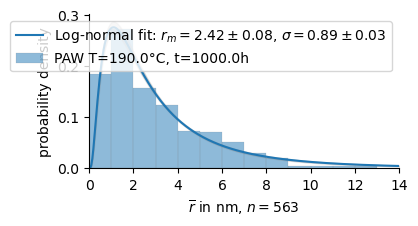

calculating distribution of T190.0°C_D8760.0hr_S0MPa with 540 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 26
    # variables        = 2
    chi-square         = 0.00733746
    reduced chi-square = 3.0573e-04
    Akaike info crit   = -208.494348
    Bayesian info crit = -205.978155
    R-squared          = 0.90731447
[[Variables]]
    sigma:  1.03970495 +/- 0.05764590 (5.54%) (init = 1)
    rm:     3.60045281 +/- 0.26972052 (7.49%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5848


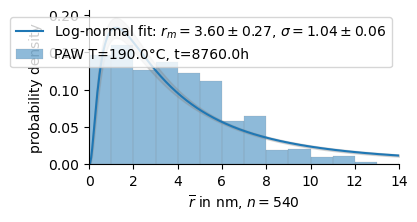

calculating distribution of T23.0°C_D0.0hr_S0MPa with 1380 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 9
    # variables        = 2
    chi-square         = 0.00178292
    reduced chi-square = 2.5470e-04
    Akaike info crit   = -72.7405630
    Bayesian info crit = -72.3461139
    R-squared          = 0.99159032
[[Variables]]
    sigma:  0.52307411 +/- 0.01474316 (2.82%) (init = 1)
    rm:     1.42194223 +/- 0.03631873 (2.55%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.7116


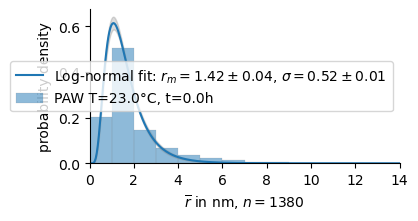

calculating distribution of T190.0°C_D25000.0hr_S0MPa with 363 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 30
    # variables        = 2
    chi-square         = 0.00572078
    reduced chi-square = 2.0431e-04
    Akaike info crit   = -252.945436
    Bayesian info crit = -250.143041
    R-squared          = 0.94788094
[[Variables]]
    sigma:  1.39412103 +/- 0.08835793 (6.34%) (init = 1)
    rm:     2.68774434 +/- 0.16777711 (6.24%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.3992


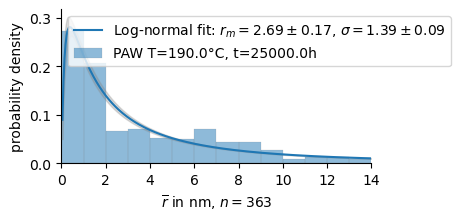

calculating distribution of T190.0°C_D2500.0hr_S0MPa with 621 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 21
    # variables        = 2
    chi-square         = 0.00164162
    reduced chi-square = 8.6401e-05
    Akaike info crit   = -194.588414
    Bayesian info crit = -192.499369
    R-squared          = 0.97897230
[[Variables]]
    sigma:  0.98399056 +/- 0.02680191 (2.72%) (init = 1)
    rm:     3.11525973 +/- 0.10896732 (3.50%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5872


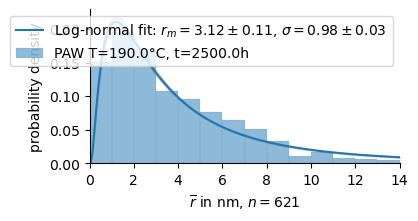

calculating distribution of T190.0°C_D250.0hr_S0MPa with 722 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 22
    # variables        = 2
    chi-square         = 0.00304265
    reduced chi-square = 1.5213e-04
    Akaike info crit   = -191.493533
    Bayesian info crit = -189.311448
    R-squared          = 0.97597959
[[Variables]]
    sigma:  0.88456101 +/- 0.02822750 (3.19%) (init = 1)
    rm:     2.18354476 +/- 0.07518593 (3.44%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.6363


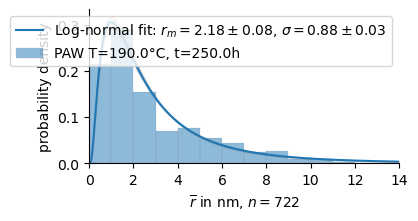

calculating distribution of T190.0°C_D5000.0hr_S0MPa with 1008 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 59
    # variables        = 2
    chi-square         = 0.00291995
    reduced chi-square = 5.1227e-05
    Akaike info crit   = -580.909805
    Bayesian info crit = -576.754730
    R-squared          = 0.98355651
[[Variables]]
    sigma:  1.09696441 +/- 0.02742413 (2.50%) (init = 1)
    rm:     1.97546059 +/- 0.04145879 (2.10%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5020


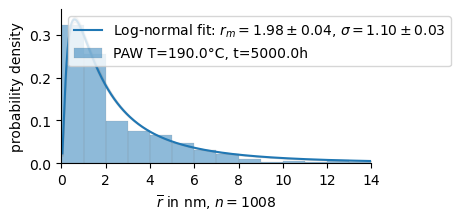

,temp,aging_time,stress,rois,chi squared,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,n_bins,start,end,bin_width
dataset,,,,,,,,,,,,,,,
T23.0°C_D0.0hr_S0MPa,23.0,0.0,0.0,https://metadata.omero.matolab.org/api/rois/51...,0.001783,1.421942,0.036319,0.523074,0.014743,1.630403,0.041643,9,0,14.0,1.0
T190.0°C_D250.0hr_S0MPa,190.0,250.0,0.0,https://metadata.omero.matolab.org/api/rois/72...,0.003043,2.183545,0.075186,0.884561,0.028227,3.229004,0.111184,22,0,14.0,1.0
T190.0°C_D1000.0hr_S0MPa,190.0,1000.0,0.0,https://metadata.omero.matolab.org/api/rois/83...,0.001455,2.416129,0.082879,0.887480,0.026335,3.582200,0.122877,13,0,14.0,1.0
T190.0°C_D2500.0hr_S0MPa,190.0,2500.0,0.0,https://metadata.omero.matolab.org/api/rois/86...,0.001642,3.115260,0.108967,0.983991,0.026802,5.055270,0.176826,21,0,14.0,1.0
T190.0°C_D5000.0hr_S0MPa,190.0,5000.0,0.0,https://metadata.omero.matolab.org/api/rois/11...,0.002920,1.975461,0.041459,1.096964,0.027424,3.605524,0.075669,59,0,14.0,1.0
T190.0°C_D8760.0hr_S0MPa,190.0,8760.0,0.0,https://metadata.omero.matolab.org/api/rois/26...,0.007337,3.600453,0.269721,1.039705,0.057646,6.181450,0.463071,26,0,14.0,1.0
T190.0°C_D25000.0hr_S0MPa,190.0,25000.0,0.0,https://metadata.omero.matolab.org/api/rois/14...,0.005721,2.687744,0.167777,1.394121,0.088358,7.102800,0.443378,30,0,14.0,1.0


In [128]:
#ignoring zero division for fit, cause it can happen while iterating
np.seterr(divide='ignore',invalid='ignore')
# create histogram and fit distrbution to found polygon areas
fits=list()
for dataset, content in poly_dict.items():
    dataframe=content['dataframe']
    props=dataset.split('_')
    temp=float(props[0][1:-2])
    aging_time=float(props[1][1:-2])
    stress=float(props[2][1:-3])
    #print(temp,aging_time,stress)
    print("calculating distribution of {} with {} polygons.".format(dataset, len(dataframe)))
    #histogram=get_histogram(dataframe['mean_radius_circle_area'],plot_result=True)
    histogram=get_histogram(dataframe['mean_radius_circle_area'],)
    #remive all special chars
    filename=''.join(e for e in dataset if e.isalnum())
    filename="images/{}.png".format(filename)
    xlabel=r"$\overline{r}$ in nm, $n=$"+str(len(dataframe))
    tmp=dataset.split('_')
    label="PAW T={}, t={}".format(tmp[0][1:],tmp[1][1:-1])
    record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'], label=label, x_min=0.0, x_max=14.0, x_label=xlabel, filename=filename,save_plot=True)}
    #record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'])}
    record.pop('fit')
    fits.append({**{'dataset': dataset, "temp": temp, "aging_time": aging_time, "stress": stress, "rois": " ".join(content['rois'])},**record})
fit_results=pd.DataFrame(fits).set_index('dataset')
fit_results.sort_values('aging_time',inplace=True)
fit_results.to_csv('fit_results.csv')
fit_results

In [17]:
# annotate fit_results.csv
response=annotate_csv_uri("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.csv")

csvw annotation file created, suggested name: fit_results-metadata.json
wrote csvw meta data to fit_results-metadata.json


In [23]:
# serialize table to rdf, uses already commited files on main branch
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
response=csvw_to_rdf(meta_url)

writen serialized table to fit_results.ttl


In [8]:
# create a rule bases mapping between the data in detection_runs and the precipitate analysis knowledge graph 
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
method_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/StatisticalAnalysisWorkflow.ttl"
d_classes= [
    "http://www.w3.org/ns/oa#Annotation",''
    "http://www.w3.org/ns/csvw#Column"
]
m_classes=["https://w3id.org/pmd/co/ValueObject",]
pred="https://w3id.org/pmd/co/isResourceOf"
map_dict={
    "precipitateRegions": "table-1-Rois",
    "ImageSetName": "table-1-Dataset",
    "binWidth": "table-1-BinWidth",
    "x-Max": "table-1-End",
    "x-Min": "table-1-Start",
    "chisqrd": "table-1-ChiSquared",
    "r_a": "table-1-Ra",
    "r_m": "table-1-Rm",
    "sigma": "table-1-Sigma",
    "stderr_r_a": "table-1-RmStderr",
    "stderr_r_a": "table-1-RaStderr",
    "stderr_sigma": "table-1-SigmaStderr",
}
create_mapping(meta_url=meta_url,method_url=method_url,data_super_classes=d_classes,predicate=pred,method_super_classes=m_classes,map_dict=map_dict)

writen mapping file to fit_results-map.yaml


True

In [29]:
# join all data and replicate template knowledge graph for every row in table
mapping_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-map.yaml"
data_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.ttl"
duplicate_for_table = True
get_joined_rdf(map_url=mapping_url,data_url=data_url,duplicate_for_table=duplicate_for_table)


applied 11 mapping rules and skipped 0
wrote joint graph to fit_results-joined.ttl


In [34]:
#merge all metadata together
df_graph=Graph()
df_graph.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs-joined.ttl",format='turtle')
df_graph.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-joined.ttl",format='turtle')
#df_graph.parse("fit_results-joined.ttl",format='turtle')
df_graph.serialize('./df-tem-paw-all.ttl',format='turtle')

<Graph identifier=N35f05c80e13c4f598c4b6bae9126ba39 (<class 'rdflib.graph.Graph'>)>

Rock_T23.0°C_D0.0hr_S0MPa
calculating distribution of Rock_T23.0°C_D0.0hr_S0MPa with 1733 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 13
    # variables        = 2
    chi-square         = 6.2978e-04
    reduced chi-square = 5.7253e-05
    Akaike info crit   = -125.156149
    Bayesian info crit = -124.026250
    R-squared          = 0.99738539
[[Variables]]
    sigma:  0.53751371 +/- 0.00661926 (1.23%) (init = 1)
    rm:     1.52657672 +/- 0.01861596 (1.22%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5938


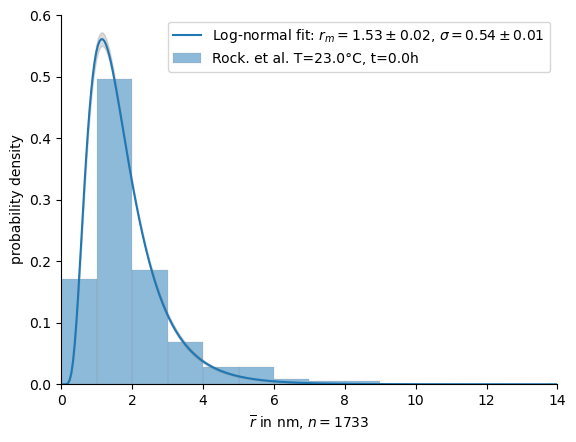

Rock_T190.0°C_D250.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D250.0hr_S0MPa with 710 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00198830
    reduced chi-square = 1.8075e-04
    Akaike info crit   = -110.210547
    Bayesian info crit = -109.080649
    R-squared          = 0.98163285
[[Variables]]
    sigma:  0.78856818 +/- 0.02396496 (3.04%) (init = 1)
    rm:     2.08473809 +/- 0.06899177 (3.31%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.6052


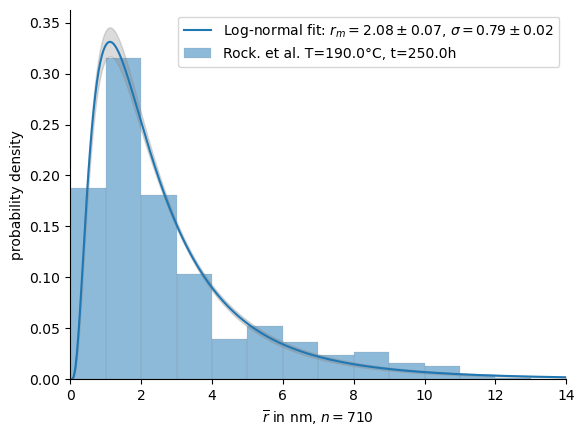

Rock_T190.0°C_D1000.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D1000.0hr_S0MPa with 306 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00364109
    reduced chi-square = 3.3101e-04
    Akaike info crit   = -102.345469
    Bayesian info crit = -101.215570
    R-squared          = 0.94036669
[[Variables]]
    sigma:  0.88320926 +/- 0.04303576 (4.87%) (init = 1)
    rm:     2.96804911 +/- 0.17825519 (6.01%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5193


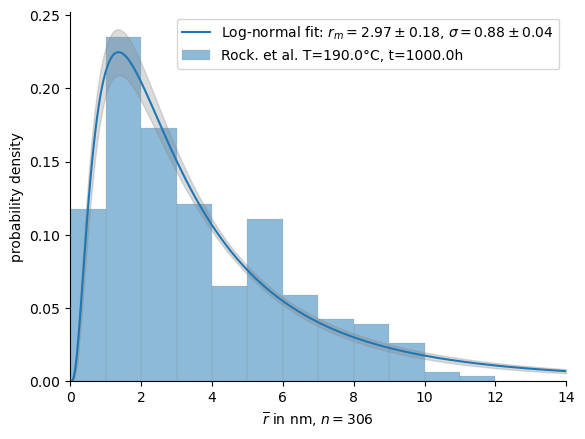

Rock_T190.0°C_D2500.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D2500.0hr_S0MPa with 358 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00258579
    reduced chi-square = 2.3507e-04
    Akaike info crit   = -106.794740
    Bayesian info crit = -105.664841
    R-squared          = 0.95396653
[[Variables]]
    sigma:  0.74318013 +/- 0.03659610 (4.92%) (init = 1)
    rm:     3.56286546 +/- 0.15601430 (4.38%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.2485


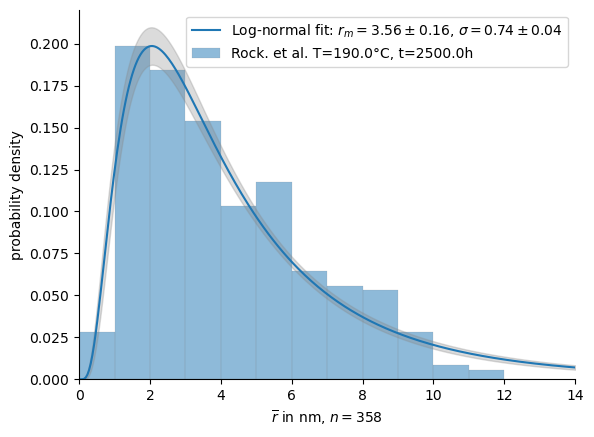

Rock_T190.0°C_D5000.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D5000.0hr_S0MPa with 331 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00254425
    reduced chi-square = 2.3130e-04
    Akaike info crit   = -107.005303
    Bayesian info crit = -105.875404
    R-squared          = 0.95146454
[[Variables]]
    sigma:  0.65197598 +/- 0.03368938 (5.17%) (init = 1)
    rm:     3.97463648 +/- 0.15153593 (3.81%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.2686


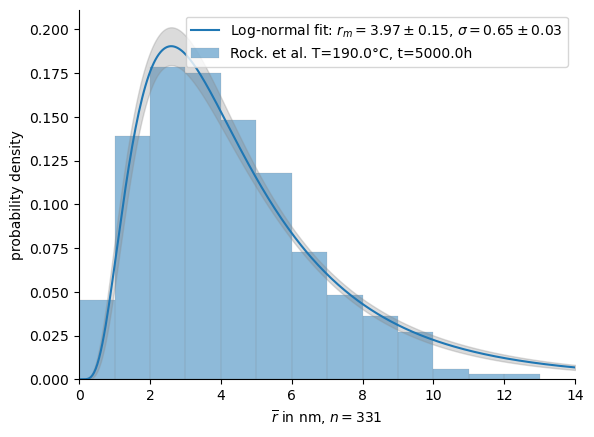

Rock_T190.0°C_D8760.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D8760.0hr_S0MPa with 300 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00428678
    reduced chi-square = 3.8971e-04
    Akaike info crit   = -100.223180
    Bayesian info crit = -99.0932812
    R-squared          = 0.92738261
[[Variables]]
    sigma:  0.39858107 +/- 0.02499908 (6.27%) (init = 1)
    rm:     5.64148733 +/- 0.17035383 (3.02%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.1759


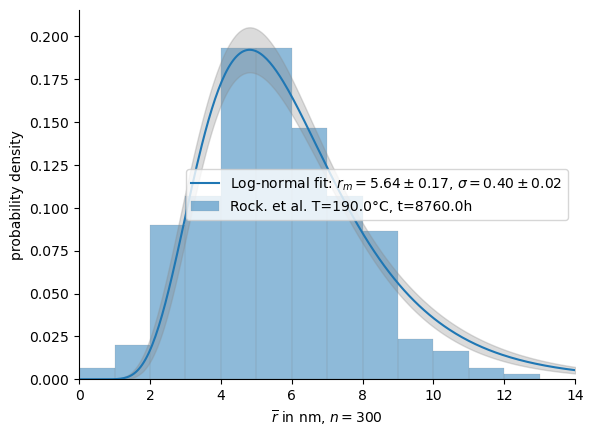

Rock_T190.0°C_D25000.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D25000.0hr_S0MPa with 188 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00548907
    reduced chi-square = 4.9901e-04
    Akaike info crit   = -97.0092950
    Bayesian info crit = -95.8793963
    R-squared          = 0.87061869
[[Variables]]
    sigma:  0.38056423 +/- 0.03072089 (8.07%) (init = 1)
    rm:     7.18560942 +/- 0.26623835 (3.71%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.2093


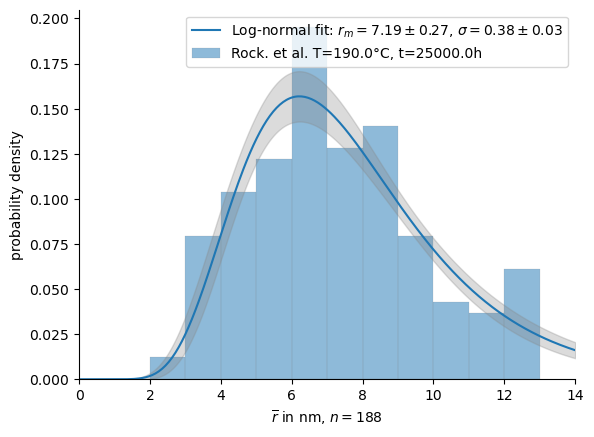

,temp,aging_time,stress,chi squared,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,n_bins,start,end,bin_width
dataset,,,,,,,,,,,,,,
Rock_T23.0°C_D0.0hr_S0MPa,23.0,0.0,0.0,0.000630,1.526577,0.018616,0.537514,0.006619,1.763831,0.021509,13,0,14.0,1.0
Rock_T190.0°C_D250.0hr_S0MPa,190.0,250.0,0.0,0.001988,2.084738,0.068992,0.788568,0.023965,2.845000,0.094152,13,0,14.0,1.0
Rock_T190.0°C_D1000.0hr_S0MPa,190.0,1000.0,0.0,0.003641,2.968049,0.178255,0.883209,0.043036,4.383880,0.263287,13,0,14.0,1.0
Rock_T190.0°C_D2500.0hr_S0MPa,190.0,2500.0,0.0,0.002586,3.562865,0.156014,0.743180,0.036596,4.696058,0.205636,13,0,14.0,1.0
Rock_T190.0°C_D5000.0hr_S0MPa,190.0,5000.0,0.0,0.002544,3.974636,0.151536,0.651976,0.033689,4.915874,0.187421,13,0,14.0,1.0
Rock_T190.0°C_D8760.0hr_S0MPa,190.0,8760.0,0.0,0.004287,5.641487,0.170354,0.398581,0.024999,6.107889,0.184438,13,0,14.0,1.0
Rock_T190.0°C_D25000.0hr_S0MPa,190.0,25000.0,0.0,0.005489,7.185609,0.266238,0.380564,0.030721,7.725256,0.286233,13,0,14.0,1.0


In [125]:
# reproduce original data
datasets={
    'Rock_T23.0°C_D0.0hr_S0MPa': "./original_data/RockT61.csv",
    'Rock_T190.0°C_D250.0hr_S0MPa': "./original_data/T1900CD2500hrS0MPa.csv",
    'Rock_T190.0°C_D1000.0hr_S0MPa': "./original_data/T1900CD10000hrS0MPa.csv",
    'Rock_T190.0°C_D2500.0hr_S0MPa': "./original_data/T1900CD25000hrS0MPa.csv",
    'Rock_T190.0°C_D5000.0hr_S0MPa': "./original_data/T1900CD50000hrS0MPa.csv",
    'Rock_T190.0°C_D8760.0hr_S0MPa': "./original_data/T1900CD87600hrS0MPa.csv",
    'Rock_T190.0°C_D25000.0hr_S0MPa': "./original_data/T1900CD250000hrS0MPa.csv"
    }
#readin data
for dataset, file in datasets.items():
    df=pd.read_csv(file,sep=';',encoding='utf-8',decimal=',')
    datasets[dataset]=df


#ignoring zero division for fit, cause it can happen while iterating
np.seterr(divide='ignore',invalid='ignore')
# create histogram and fit distrbution to found polygon areas
fits=list()
for dataset, dataframe in datasets.items():
    print(dataset)
    props=dataset.split('_')
    temp=float(props[1][1:-2])
    aging_time=float(props[2][1:-2])
    stress=float(props[3][1:-3])
    #dataframe.plot('Radius [nm]')
    print("calculating distribution of {} with {} polygons.".format(dataset, len(dataframe)))
    #histogram=get_histogram(dataframe['mean_radius_circle_area'],plot_result=True)
    histogram=get_histogram(dataframe['Radius [nm]'],end=14.0)
    #remive all special chars
    filename=''.join(e for e in dataset if e.isalnum())
    filename="images/{}.png".format(filename)
    xlabel=r"$\overline{r}$ in nm, $n=$"+str(len(dataframe))
    tmp=dataset.split('_')
    label="Rock. et al. T={}, t={}".format(tmp[1][1:],tmp[2][1:-1])
    record={**{'dataset': dataset, "temp": temp, "aging_time": aging_time, "stress": stress},**fit_log_distribution(histogram['center'],histogram['norm'],x_min=0.0, x_max=14.0, label=label, x_label=xlabel, filename=filename,save_plot=True)}
    #record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'])}
    record.pop('fit')
    fits.append({**{'dataset': dataset},**record})
fit_results=pd.DataFrame(fits).set_index('dataset')
fit_results.sort_values('aging_time',inplace=True)
fit_results.to_csv('org_fit_results.csv')
fit_results

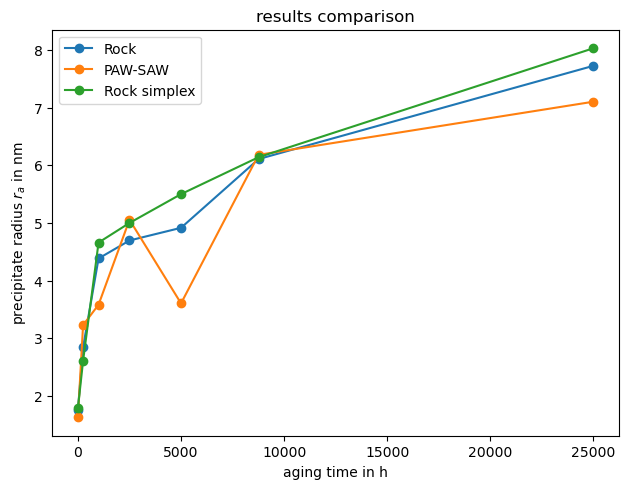

In [100]:
#compare results
datasets={
    'Rock': "./org_fit_results.csv",
    'PAW-SAW': "./fit_results.csv"
    }
#readin data
for dataset, file in datasets.items():
    df=pd.read_csv(file)
    #print(dataset, df)
    datasets[dataset]=df

org_results_rm =[1.79, 2.61, 4.66, 5.0, 5.5, 6.14, 8.03]
org_results_rm_stderr =[0.05, 0.12, 0.53, 0.42, 0.6, 0.23, 0.25]


fig=plt.figure()
plt.title(r"results comparison")
   
filename="./images/compare_results.png"
plt.tight_layout()

for dataset, dataframe in datasets.items():
#    #ax.yaxis.grid(True, color='#EEEEEE')
#    #ax.xaxis.grid(False)
   plt.plot(dataframe['aging_time'], dataframe['ra'],marker='o', label=dataset)
#    plt.plot(fit['x'], fit['y'], label='fit')
#    plt.fill_between(fit['x'], fit['y']-fit['dely'],
#          fit['y']+fit['dely'], color='#888888',alpha=0.3)
plt.xlabel('aging time in h')
#    plt.xlim(left=x_min,right=x_max)
#    plt.ylim(bottom=0)
#    bar_color = bars[0].get_facecolor()
#    if y_max:
#       plt.ylim(top=y_max)
   
#    #plt.xticks(x)
plt.ylabel(r"precipitate radius $r_a$ in nm")
# ax=plt.axes()
# #    #ax.set_facecolor((.94, .94, .94))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.plot(dataframe['aging_time'], org_results_rm,marker='o', label='Rock simplex')
plt.legend()

plt.show()
   
fig.savefig(filename)
plt.close(fig)   

